In [2]:
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import os
from astropy.io import fits

# constructing the telescope:
wf_npixels = 256 # nice and low res
diameter = 0.125
period = 200e-6#304e-6
difference = np.pi * 0.348

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 450
true_pixel_scale = 0.375
oversample = 2 # high level oversample

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,true_pixel_scale,oversample)

In [3]:
filename = os.path.join("spectra", "ADP.2014-10-01T10:19:26.300.fits")

hdul = fits.open(filename)

hdul.info()  # Print summary of extensions

# Explore structure - usually HARPS spectra are in the first extension or primary HDU
# For 1D extracted spectrum:

# Access the binary table in extension 1
table_data = hdul[1].data
columns = hdul[1].columns

print(columns)

# Inspect column names
print(table_data.columns.names)

Filename: spectra/ADP.2014-10-01T10:19:26.300.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    3042   ()      
  1  SPECTRUM      1 BinTableHDU     45   1R x 3C   [313134D, 313134E, 313134E]   
ColDefs(
    name = 'WAVE'; format = '313134D'; unit = 'Angstrom'
    name = 'FLUX'; format = '313134E'; unit = 'adu'
    name = 'ERR'; format = '313134E'; unit = 'adu'
)
['WAVE', 'FLUX', 'ERR']


In [4]:
# Assuming columns are called 'WAVE', 'FLUX', 'ERR' (this is common)
wavelength = table_data['WAVE'][0]
flux = table_data['FLUX'][0]

In [5]:
import pandas as pd
from scipy.stats import binned_statistic

# Step 1: Load from CSV
df = pd.read_csv("B_low_res_nonHARPS.csv")  # replace with correct path if needed

# Step 2: Apply mask (wavelengths in Ångstroms, like original)
mask = (df["wavelength"] >= 5200) & (df["wavelength"] <= 6500)

# Step 3: Extract and convert to meters
wavelengths = df["wavelength"][mask].to_numpy() * 1e-10  # meters
weights = df["flux"][mask].to_numpy()

lambda0 = 585*10**(-9)
f_cutoff = (np.sqrt(2) / period) * (diameter / lambda0) 
f_cutoff_2 = 5*f_cutoff

dw = np.diff(wavelengths)
weights_fft = np.fft.fft(weights)
freqs = np.fft.fftfreq(len(weights), d=dw[0])
mask_freqs = np.abs(freqs) > f_cutoff
weights_fft = weights_fft.at[mask_freqs].set(0)
weights_filtered = np.fft.ifft(weights_fft).real

mask_freqs_2 = np.abs(freqs) > f_cutoff_2
weights_fft_2 = np.fft.fft(weights)
weights_fft_2 = weights_fft_2.at[mask_freqs_2].set(0)
weights_filtered_2 = np.fft.ifft(weights_fft_2).real


#Step 4: Downsample using binning
n_bins = 500
bin_means, bin_edges, _ = binned_statistic(
    wavelengths, weights, statistic='mean', bins=n_bins
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
#Step 5: Create the point source
alpha_cen_b_source = dl.PointSource(
    wavelengths=bin_centers,
    weights=bin_means,
    flux=4*1000*9.023*10**6 # from max charles code. 4000 exposures
)

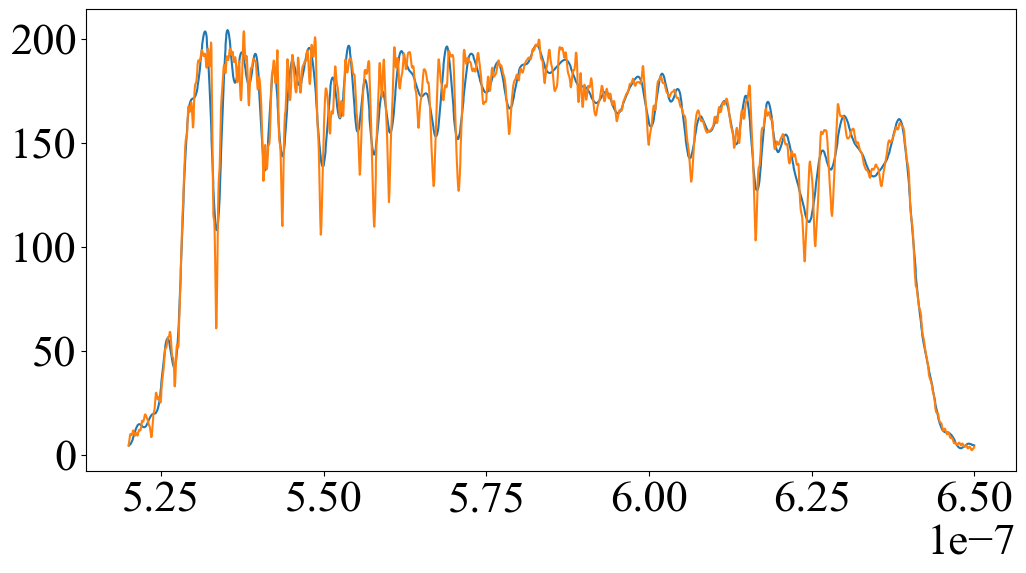

In [6]:
plt.figure(figsize=(12,6))
#plt.plot(bin_centers, bin_means)
plt.plot(wavelengths, weights_filtered)
plt.plot(wavelengths, weights_filtered_2)

plt.show()

In [7]:
alpha_cen_b_scope = dl.Telescope(optics,alpha_cen_b_source)

sidelobescope = dlT.SideLobeTelescope(alpha_cen_b_scope, period, difference)

In [8]:
import jax.random as jr # jax random
key = 0

In [9]:
center_wl = 585e-9
pixel_scale = 0.375
# make sure to downsample!, then apply jax random poisson noise!
sidelobes = jr.poisson(jr.PRNGKey(key), dlu.downsample(sidelobescope.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = pixel_scale),oversample,False) )

Model time: 21.1096 seconds.


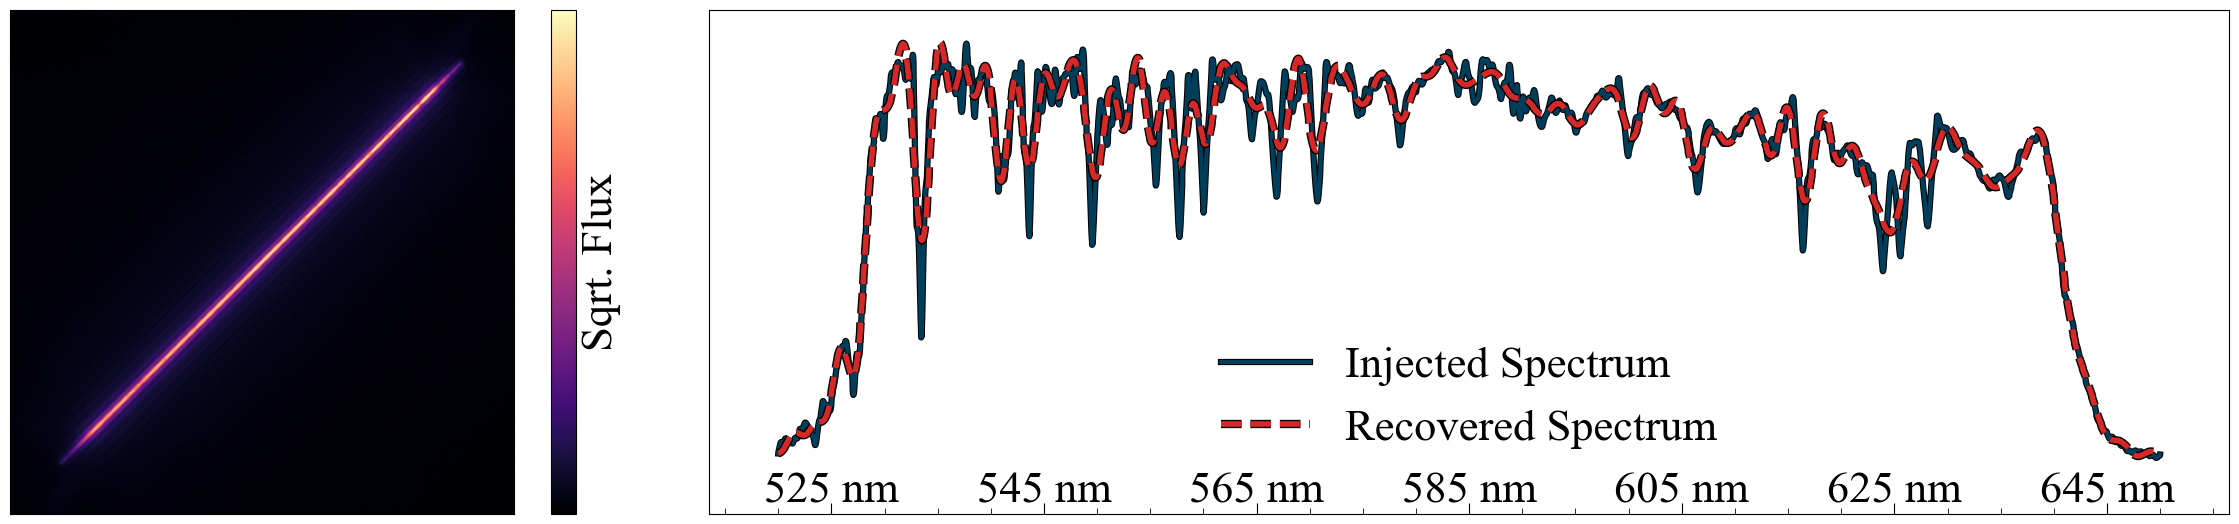

In [67]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=4.5, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=6, foreground='k'), pe.Normal()]

# Times New Roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.rm"] = "Times New Roman"
plt.rcParams["font.size"] = 32

cmap = plt.get_cmap('magma')
norm = colors.Normalize(vmin=0, vmax=99)  # Normalize iteration range

# Create figure and gridspec
fig = plt.figure(figsize=(24,6))
gs = gridspec.GridSpec(1, 3, figure=fig)

# First subplot (column 1)
ax1 = fig.add_subplot(gs[0, 0])
im = ax1.imshow(sidelobes**0.4, origin='lower', cmap=cmap)
#ax1.set_title('Injected Sidelobe')
# ax1.set_xlabel('Pixels')
# ax1.set_ylabel('Pixels')

tick_spacing = 50
image_shape = sidelobes.shape
# ax1.set_xticks(np.arange(0, image_shape[1], tick_spacing))
# ax1.set_yticks(np.arange(0, image_shape[0], tick_spacing))
ax1.set_xticks([])
ax1.set_yticks([])

cbar1 = fig.colorbar(im, ax=ax1)
cbar1.set_ticks([])  # remove tick marks and labels
cbar1.ax.set_ylabel('Sqrt. Flux')

# ax1.text(0.05, 0.95, '(a)', transform=ax1.transAxes,
#          fontsize=32, va='top', ha='left', color='white')

# Second subplot spans columns 2 and 3
ax2 = fig.add_subplot(gs[0, 1:3])

# for i in range(100):
#     output_weights = models_out[i].telescope.source.spectrum.weights / np.sum(models_out[i].telescope.source.spectrum.weights)
#     color = cmap(1 - i / 99)
#     ax2.plot(bin_centers * 1e9, output_weights, color=color, linewidth=1)

# ax2.tick_params(axis='y', left=False, labelleft=False)
# #ax2.set_xlabel("Wavelength [nm]")
# #ax2.set_title("Injected & Recovered Spectra")
# ax2.set_xticks([])

# Only keep bottom ticks
ax2.tick_params(axis='x', which='both',
                bottom=True, top=False, direction='in',
                labelbottom=True)

# Hide all y ticks and labels
ax2.tick_params(axis='y', which='both',
                left=False, right=False, labelleft=False)

# Move the x tick labels inside the plot
ax2.tick_params(axis='x', pad=-30)  # negative pad moves labels inside

# making ticks
nm_min = int(np.floor((wavelengths.min()*1e9)/20) * 20)
nm_max = int(np.ceil((wavelengths.max()*1e9)/20) * 20)
ticks_nm = np.arange(nm_min+5, nm_max+1, 20)

ax2.set_xticks(ticks_nm)
ax2.tick_params(axis='x',which='major',direction='in',length=8)
ax2.set_xticklabels([f"{t} nm" for t in ticks_nm])
# ax2.set_xticklabels([f"{int(tick)} nm" for tick in xticks])

# Optional: make minor ticks inside too, without labels
from matplotlib.ticker import AutoMinorLocator
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(axis='x', which='minor', direction='in', length=4)

# Overlay true spectrum
ax2.plot(wavelengths * 1e9, weights_filtered_2, color='#003F5C', linestyle='-', linewidth=3, label='Injected Spectrum',
         path_effects = text_path_effects)

ax2.plot(wavelengths * 1e9, weights_filtered,color='#D62828',
         linewidth=4,label='Recovered Spectrum',linestyle='--',path_effects=path_effects)

ax2.set_ylim(-25,220)
# ax2.text(0.02, 0.95, '(b)', transform=ax2.transAxes,
#          fontsize=32, va='top', ha='left', color='black')

# Combine and add to legend
ax2.legend(loc='lower center',bbox_to_anchor=(0.5, 0.05), frameon=False)

plt.tight_layout()
plt.savefig('injected_recovered_final_nolabel.pdf', dpi=300, bbox_inches='tight')
plt.show()
